In [12]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime
from netCDF4 import Dataset


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat,upslope_omega_sin
from orographicPrecipitation.precip_extremes_scaling import *
from wrfProcessing import *

import warnings
from tabulate import tabulate

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore",FutureWarning)
    
    Mcont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.mountain.100km.1000d"              ,"Mountain, control"         ,sel_tropicmountain,open_ds=0)
    Mwarm = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.mountain.100km.SST2K_2XCO2.1000d"  ,"Mountain, SST +2K, 2*CO2"  ,sel_tropicmountain,open_ds=0)
    Acont = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.aquaplanet.100km.1000d"            ,"Aquaplanet, control"       ,sel_tropicmountain,open_ds=0)
    Awarm = WrfDataset100km("/global/cscratch1/sd/qnicolas/wrfdata/processed","wrf.aquaplanet.100km.SST2K_2XCO2.1000d","Aquaplanet, SST +2K, 2*CO2",sel_tropicmountain,open_ds=0)

loading time : 0.0 s
Daily precips already computed
precips time : 0.8 s
loading time : 0.0 s
Daily precips already computed
precips time : 0.2 s
loading time : 0.0 s
Daily precips already computed
precips time : 0.1 s
loading time : 0.0 s
Daily precips already computed
precips time : 0.0 s


In [20]:
def set_pctile(pctile):
    for ds in [Mcont,Mwarm,Acont,Awarm]:
        ds.set_extreme_precip(pctile/100)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore",RuntimeWarning)
            warnings.simplefilter("ignore",FutureWarning)
            ds.set_extreme_vars(pctile/100)
            ds.compute_ogscaling()

In [21]:
pctile=99
set_pctile(pctile)

# Zonal-mean precip

In [3]:
print("Mean precip increase, Mountain %.2f%%/K"%  (100*(spatial_mean(Mwarm.precip_daily.mean("time"))/spatial_mean(Mcont.precip_daily.mean("time")) - 1)))
print("Mean precip increase, Aquaplanet %.2f%%/K"%(100*(spatial_mean(Awarm.precip_daily.mean("time"))/spatial_mean(Acont.precip_daily.mean("time")) - 1)))


Mean precip increase, Mountain 6.42%/K
Mean precip increase, Aquaplanet 6.51%/K


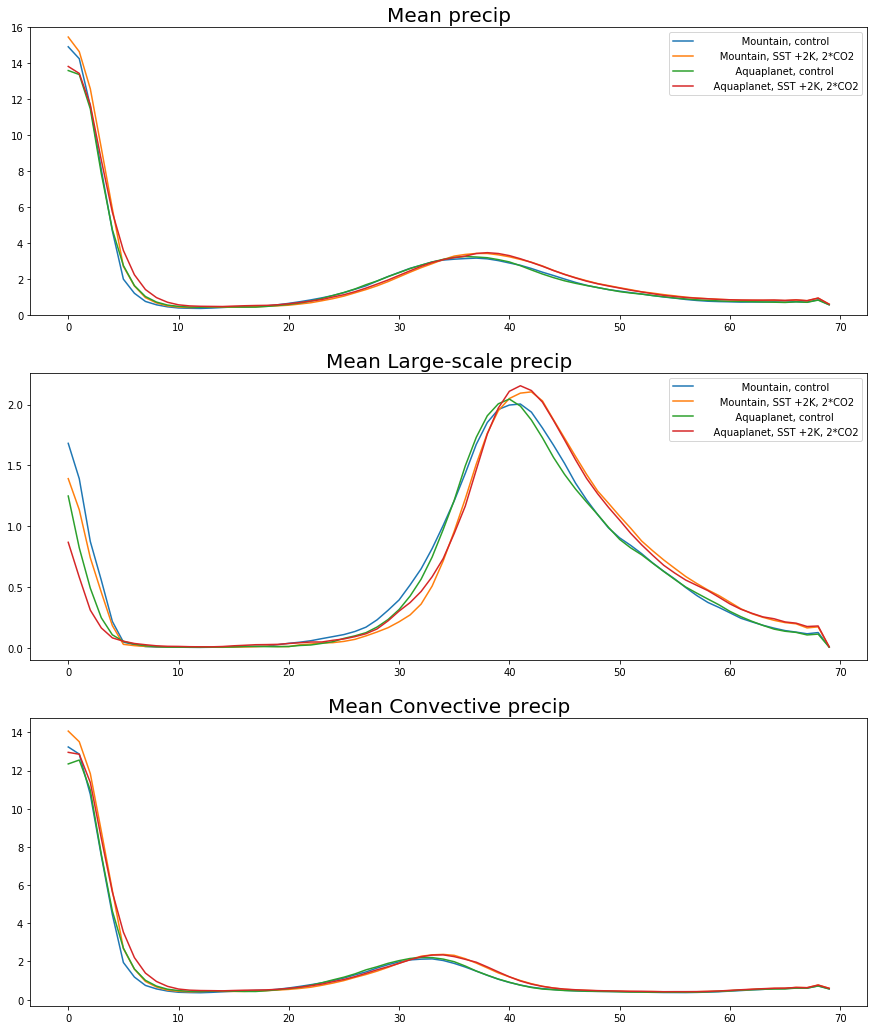

In [26]:
fig, ax = plt.subplots(3,1,figsize=(15,3*6))
props = plt.rcParams['axes.prop_cycle'].by_key()['color']
i=0
for ds in [Mcont,Mwarm,Acont,Awarm]:
    ax[0].plot(ds.vars.south_north,ds.precip_daily.mean(["time","west_east"]),  label="{:>30}".format(ds.lbl)  ,color=props[i])
    ax[1].plot(ds.vars.south_north,ds.precip_g_daily.mean(["time","west_east"]),label="{:>30}".format(ds.lbl),color=props[i])
    ax[2].plot(ds.vars.south_north,ds.precip_c_daily.mean(["time","west_east"]),label="{:>30}".format(ds.lbl),color=props[i])
    i+=1

ax[0].set_title("Mean precip",fontsize=20)
ax[1].set_title("Mean Large-scale precip",fontsize=20)
ax[2].set_title("Mean Convective precip",fontsize=20)
ax[0].set_ylim(0,16)

for a in ax[:-1] :a.legend()

# Precipitation extremes

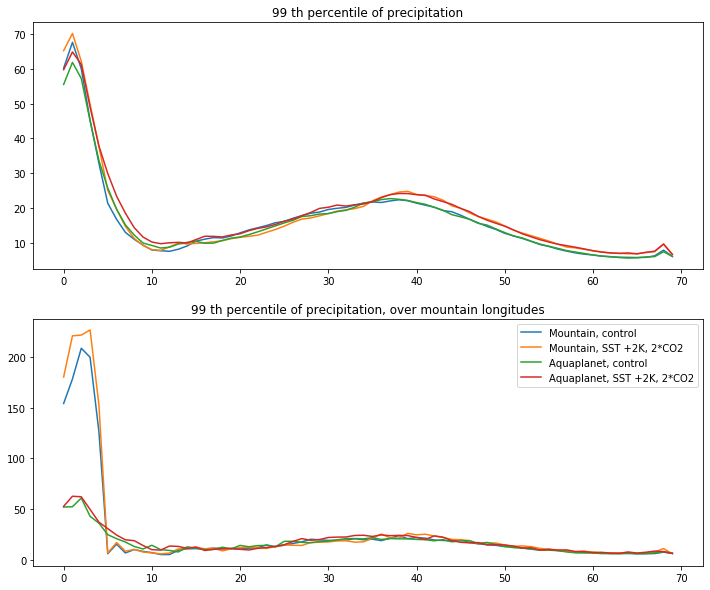

In [6]:
fig, ax = plt.subplots(2,1,figsize=(12,10))

for ds in [Mcont,Mwarm,Acont,Awarm]:
    ax[0].plot(ds.ex_pr.south_north,ds.ex_pr_zonmean,label=ds.lbl)
    ax[0].set_title("%i th percentile of precipitation"%pctile)
    ax[1].plot(ds.ex_pr.south_north,ds.ex_pr.sel(west_east=slice(38,40)).mean("west_east"),label=ds.lbl)
    ax[1].set_title("%i th percentile of precipitation, over mountain longitudes"%pctile)
plt.legend()

## Vertical motion profiles over tropics/mountains on precip extremes days

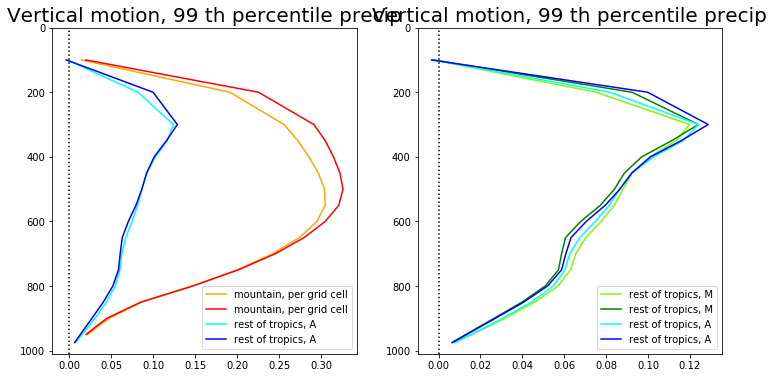

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))


with warnings.catch_warnings():
    warnings.simplefilter("ignore",category=RuntimeWarning)
    ax=ax1
    ax.plot(Mcont.ex_w.isel(south_north=range(5),west_east=range(38,40)).mean(["south_north","west_east"]),Mcont.ex_w.level,label="mountain, per grid cell",color="orange")
    ax.plot(Mwarm.ex_w.isel(south_north=range(5),west_east=range(38,40)).mean(["south_north","west_east"]),Mwarm.ex_w.level,label="mountain, per grid cell",color="red")

    ax.plot(Acont.ex_w.isel(south_north=range(5)).mean(["south_north","west_east"]),Acont.ex_w.level,label="rest of tropics, A",color="cyan")
    ax.plot(Awarm.ex_w.isel(south_north=range(5)).mean(["south_north","west_east"]),Awarm.ex_w.level,label="rest of tropics, A",color="blue")

    ax=ax2
    ax.plot(Mcont.ex_w.isel(south_north=range(5)).sel(west_east=((Mcont.ex_w.west_east<20)|(Mcont.ex_w.west_east>60))).mean(["south_north","west_east"]),Mcont.ex_w.level,label="rest of tropics, M",color="lawngreen")
    ax.plot(Mwarm.ex_w.isel(south_north=range(5)).sel(west_east=((Mwarm.ex_w.west_east<20)|(Mwarm.ex_w.west_east>60))).mean(["south_north","west_east"]),Mwarm.ex_w.level,label="rest of tropics, M",color="green")
    
    ax.plot(Acont.ex_w.isel(south_north=range(5)).mean(["south_north","west_east"]),Acont.ex_w.level,label="rest of tropics, A",color="cyan")
    ax.plot(Awarm.ex_w.isel(south_north=range(5)).mean(["south_north","west_east"]),Awarm.ex_w.level,label="rest of tropics, A",color="blue")

    
for ax in (ax1,ax2):
    ax.axvline(0,linestyle=':',color='k')
    ax.set_title("Vertical motion, %i th percentile precip"%pctile,fontsize=20)
    ax.legend(loc='lower right')
    ax.set_ylim(1010,0)
    



## Extreme precipitation sensitivity

Text(0.5, 0.98, 'Sensitivity of the 99 th pctile of precip, %/(K of global mean temperature)')

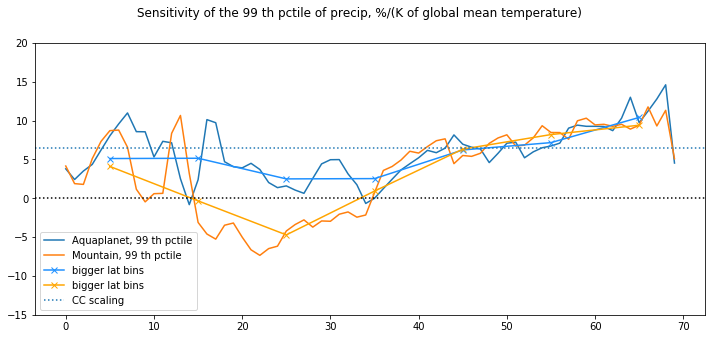

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(Acont.ex_pr.south_north,100*(Awarm.ex_pr_zonmean-Acont.ex_pr_zonmean)/Acont.ex_pr_zonmean/2, label = "Aquaplanet, %i th pctile"%pctile)
ax.plot(Mcont.ex_pr.south_north,100*(Mwarm.ex_pr_zonmean-Mcont.ex_pr_zonmean)/Mcont.ex_pr_zonmean/2, label = "Mountain, %i th pctile"%pctile)


with warnings.catch_warnings():
    warnings.simplefilter("ignore",category=FutureWarning)       
    resample_factor=10
    resampled_pr95_Mwarm = Mwarm.ex_pr.groupby(((Mwarm.ex_pr.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
    resampled_pr95_Mcont = Mcont.ex_pr.groupby(((Mcont.ex_pr.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
    resampled_pr95_Awarm = Awarm.ex_pr.groupby(((Awarm.ex_pr.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")
    resampled_pr95_Acont = Acont.ex_pr.groupby(((Acont.ex_pr.south_north//resample_factor)+0.5) * resample_factor).mean('south_north').mean("west_east")

ax.plot(resampled_pr95_Awarm.south_north,100*(resampled_pr95_Awarm-resampled_pr95_Acont)/resampled_pr95_Acont/2.,'-x',color='dodgerblue',label="bigger lat bins")
ax.plot(resampled_pr95_Mwarm.south_north,100*(resampled_pr95_Mwarm-resampled_pr95_Mcont)/resampled_pr95_Mcont/2.,'-x',color='orange',label="bigger lat bins")

ax.axhline(6.5,linestyle=":",label="CC scaling")
ax.axhline(0.,linestyle=":",color="k")

ax.set_ylim(-15,20)

plt.legend()
fig.suptitle("Sensitivity of the %i th pctile of precip, %%/(K of global mean temperature)"%pctile)

## Sensitivity breakdown (Fildier et al 2017)

In [18]:
tropics_limit=5

def mean_mountain(x):
    return x.isel(south_north=range(5),west_east=range(38,40)).mean(['west_east','south_north'])
def mean_lee(x):
    return x.isel(south_north=range(5),west_east=range(40,42)).mean(['west_east','south_north'])
def mean_rest_tropics(x):
    return x.isel(south_north=range(tropics_limit)).sel(west_east=((x.west_east<20)|(x.west_east>60))).mean(['west_east','south_north'])

def mean_tropics(x):
    return x.isel(south_north=range(tropics_limit)).mean(['west_east','south_north'])
def mean_midlatitudes(x):
    return x.isel(south_north=range(40,60)).mean(['west_east','south_north'])

In [19]:
def bsensitivity_breakdown(cont,warm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=1):
    meanTinc=2
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",category=RuntimeWarning)
                      
        prsensm  = bPR(cont,warm,meanTinc,mean_mountain    )
        prsensl  = bPR(cont,warm,meanTinc,mean_lee         )
        prsenst  = bPR(cont,warm,meanTinc,mean_tropics     )
        prsenss  = bPR(cont,warm,meanTinc,mean_subtropics  )
        prsense  = bPR(cont,warm,meanTinc,mean_midlatitudes)
        
        em  = bE(cont,warm,meanTinc,mean_mountain    )
        el  = bE(cont,warm,meanTinc,mean_lee         )
        et  = bE(cont,warm,meanTinc,mean_tropics     )
        es  = bE(cont,warm,meanTinc,mean_subtropics  )
        ee  = bE(cont,warm,meanTinc,mean_midlatitudes)
        
        d1m  = bD1(cont,warm,meanTinc,mean_mountain    )
        d1l  = bD1(cont,warm,meanTinc,mean_lee         )
        d1t  = bD1(cont,warm,meanTinc,mean_tropics     )
        d1s  = bD1(cont,warm,meanTinc,mean_subtropics  )
        d1e  = bD1(cont,warm,meanTinc,mean_midlatitudes)
        
        d2m  = bD2(cont,warm,meanTinc,mean_mountain    )
        d2l  = bD2(cont,warm,meanTinc,mean_lee         )
        d2t  = bD2(cont,warm,meanTinc,mean_tropics     )
        d2s  = bD2(cont,warm,meanTinc,mean_subtropics  )
        d2e  = bD2(cont,warm,meanTinc,mean_midlatitudes)
        
        thm  = bT(cont,warm,meanTinc,mean_mountain    )
        thl  = bT(cont,warm,meanTinc,mean_lee         )
        tht  = bT(cont,warm,meanTinc,mean_tropics     )
        ths  = bT(cont,warm,meanTinc,mean_subtropics  )
        the  = bT(cont,warm,meanTinc,mean_midlatitudes)
        
    print(' '*30+'\033[1m'+ "Extreme precip sensitivity breakdown, %i th percentile"%pctile + '\033[0m')
    
    tab=[['Tropics - 0°-%i°'%tropics_limit ,"%.2f"%(100*prsenst),"%.2f"%(100*et),"%.2f"%(100*d1t),"%.2f"%(100*d2t),"%.2f"%(100*tht),"%.2f"%(100*(prsenst-et-d1t-d2t-tht))],
         ['Midlatitudes - 40°-60°',         "%.2f"%(100*prsense),"%.2f"%(100*ee),"%.2f"%(100*d1e),"%.2f"%(100*d2e),"%.2f"%(100*the),"%.2f"%(100*(prsense-ee-d1e-d2e-the))],
        ]
    if mountain :
        tab += [['Mountain - Windward slope',"%.2f"%(100*prsensm),"%.2f"%(100*em),"%.2f"%(100*d1m),"%.2f"%(100*d2m),"%.2f"%(100*thm),"%.2f"%(100*(prsensm-em-d1m-d2m-thm))],
                ['Mountain - Lee',           "%.2f"%(100*prsensl),"%.2f"%(100*el),"%.2f"%(100*d1l),"%.2f"%(100*d2l),"%.2f"%(100*thl),"%.2f"%(100*(prsensl-el-d1l-d2l-thl))],
               ]
    
    print(tabulate(tab, headers=['Region', 'Precip (%)', 'Efficiency (%)', 'D1 (%)', 'D2 (%)', 'T (%)', 'N (%)']))


In [22]:
print("Tropics Mountain")
t=time.time()
bsensitivity_breakdown(Mcont,Mwarm,pctile,mean_rest_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=1)
print(time.time()-t)
print("Aquaplanet")
t=time.time()
bsensitivity_breakdown(Acont,Awarm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=0)
print(time.time()-t)

Tropics Mountain
                              Extreme precip sensitivity breakdown, 99 th percentile
Region                       Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
-------------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                    2.23              1.47     -1.29     -1.51     5.92    -2.38
Midlatitudes - 40°-60°             6.98              0.72      1.76     -1.03     6.9     -1.36
Mountain - Windward slope          7.78              0.21      3.82     -0.71     5.79    -1.34
Mountain - Lee                     1.44              1.47     -1.15     -2.37     6.72    -3.24
121.28165674209595
Aquaplanet
                              Extreme precip sensitivity breakdown, 99 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°      

In [23]:
pctile=95
set_pctile(pctile)
print("Tropics Mountain")
t=time.time()
bsensitivity_breakdown(Mcont,Mwarm,pctile,mean_rest_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=1)
print(time.time()-t)
print("Aquaplanet")
t=time.time()
bsensitivity_breakdown(Acont,Awarm,pctile,mean_tropics,mean_midlatitudes,mean_mountain,mean_lee,mountain=0)
print(time.time()-t)

Tropics Mountain
                              Extreme precip sensitivity breakdown, 95 th percentile
Region                       Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
-------------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°                    2.01              1.6      -2.21     -1.57     6.32    -2.13
Midlatitudes - 40°-60°             7.24              0.52      1.9      -0.96     7.14    -1.35
Mountain - Windward slope          7.61              1.37      2.4      -0.72     6.03    -1.47
Mountain - Lee                     2.34              1.04     -3.07     -1.7      8.4     -2.33
120.55907201766968
Aquaplanet
                              Extreme precip sensitivity breakdown, 95 th percentile
Region                    Precip (%)    Efficiency (%)    D1 (%)    D2 (%)    T (%)    N (%)
----------------------  ------------  ----------------  --------  --------  -------  -------
Tropics - 0°-5°      